In [1]:
import nle.dataset as nld
from nle.nethack import tty_render

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from nle.dataset import db


In [2]:
nld_nao_path = "/code/nld-nao/nld-nao-unzipped"

dbfilename = "/code/persistence/nld-nao.db"

dataset_name = "nld-nao"

In [3]:
if not nld.db.exists(dbfilename):
    nld.db.create(dbfilename)
    # Add NLD-NAO data, use the `add_altorg_directory`.
    nld.add_altorg_directory(nld_nao_path, "nld-nao", dbfilename)

In [4]:
db_conn = nld.db.connect(filename=dbfilename)
print(f"AltOrg Dataset has {nld.db.count_games('nld-nao', conn=db_conn)} games.")

AltOrg Dataset has 1511228 games.


In [5]:
dataset = nld.TtyrecDataset(
    "nld-nao",
    batch_size=32,
    seq_length=32,
    dbfilename=dbfilename,
)

minibatch = next(iter(dataset))
minibatch.keys()

dict_keys(['tty_chars', 'tty_colors', 'tty_cursor', 'timestamps', 'done', 'gameids'])

In [6]:
def get_dataset_stats(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)
    
    sql = """
    SELECT games.gameid, games.points, games.turns, games.maxlvl
    FROM games
    INNER JOIN datasets ON games.gameid=datasets.gameid
    WHERE datasets.dataset_name=?"""

    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        stats = pd.DataFrame(data, columns=["gameid", "points", "turns", "maxlvl"])
    return stats


OptionError: No such keys(s): 'mode.use_inf_as_null'

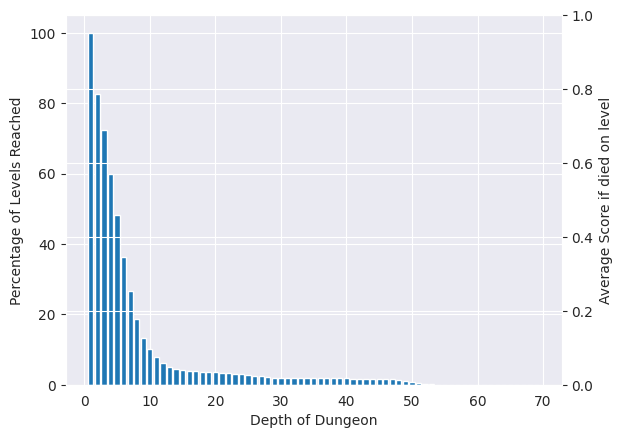

In [7]:
df = get_dataset_stats(dataset_name, dbfilename)
# Example 
levels_reached = df["maxlvl"]
depths = sorted(set(range(1, max(levels_reached) + 1)))
percentage = [sum(1 for level in levels_reached if level >= depth) / len(levels_reached) * 100 for depth in depths]

fig, ax1 = plt.subplots()
ax1.bar(depths, percentage)
ax1.set_xlabel("Depth of Dungeon")
ax1.set_ylabel("Percentage of Levels Reached")

# Create second plot with seaborn
ax2 = ax1.twinx()
ax2.set_ylabel("Average Score if died on level")
sns.lineplot(df, x="maxlvl", y="points", color="red", errorbar=('ci', 90), ax=ax2)

plt.title(f"Average Percentage of Levels Reached by NLD-NAO")
plt.show()

In [8]:
def get_dataset_scores(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)

    sql = """
    SELECT games.gameid, games.points
    FROM games
    INNER JOIN datasets ON games.gameid=datasets.gameid
    WHERE datasets.dataset_name=?"""

    with db.connect(dbfilename) as conn:
        scores = dict(list(conn.execute(sql, sql_args)))
    return scores

Text(0.5, 1.0, 'NLD-NAO (mean=127217)')

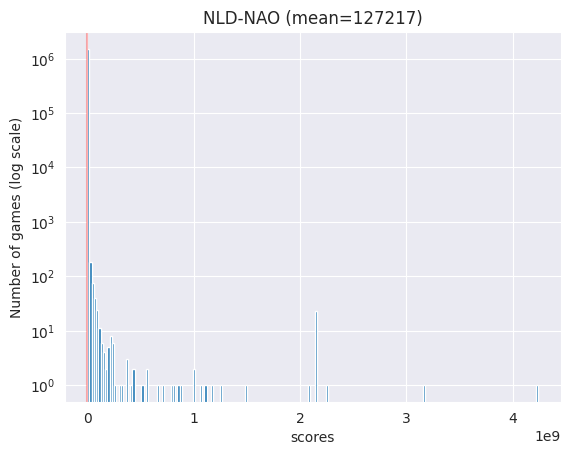

In [9]:
dataset_scores = get_dataset_scores("nld-nao", dbfilename)
nao_scores = np.array(list(dataset_scores.values()))
score = np.percentile(list(dataset_scores.values()), q=95)
plt.hist(nao_scores, bins=200)
plt.axvline(x=score, c="red", alpha=0.3)
plt.ylabel('Number of games (log scale)')
plt.xlabel('scores')
plt.yscale('log')
plt.title(f"NLD-NAO (mean={nao_scores.mean().astype(int)})")


In [10]:
def get_persistence_stats(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)
    
    sql = """
    SELECT games.gameid, games.name, games.points, games.starttime
    FROM games
    INNER JOIN datasets ON games.gameid = datasets.gameid
    WHERE datasets.dataset_name=?
    ORDER BY games.name, games.starttime
    """

    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        stats = pd.DataFrame(data, columns=["gameid", "name", "points", "starttime"])
    return stats

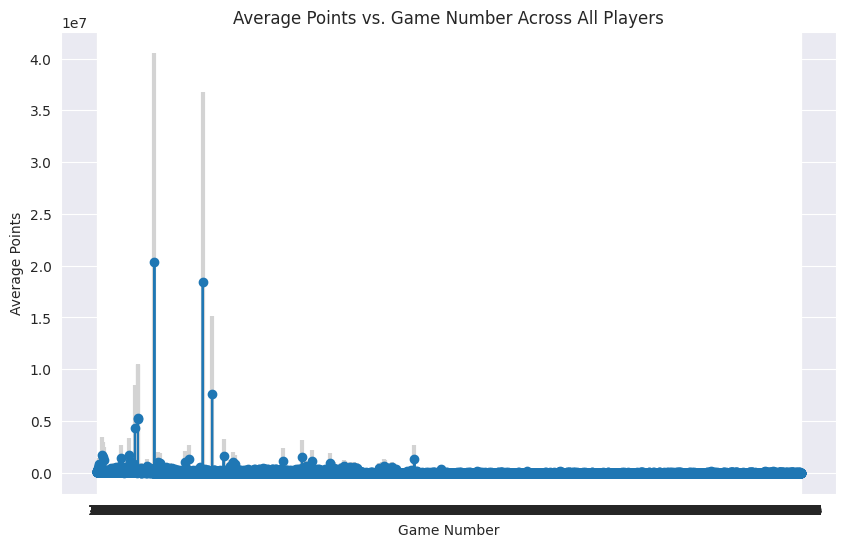

In [11]:
# Retrieve persistence statistics
df = get_persistence_stats(dataset_name, dbfilename)

# Convert 'starttime' to datetime
df['starttime'] = pd.to_datetime(df['starttime'])

# Sort by 'playerid' and 'starttime'
df = df.sort_values(['name', 'starttime'])

# Assign game numbers to each player's games
df['game_number'] = df.groupby('name').cumcount() + 1

# Calculate average points per game number across all players
avg_points_per_game = df.groupby('game_number')['points'].mean()
std_points_per_game = df.groupby('game_number')['points'].std()
count_per_game = df.groupby('game_number')['points'].count()

# Compute standard error
std_error = std_points_per_game / np.sqrt(count_per_game)

# Plot average points vs. game number with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(avg_points_per_game.index, avg_points_per_game.values, yerr=std_error.values, fmt='-o', ecolor='lightgray', elinewidth=3, capsize=0)
ax.set_xlabel('Game Number')
ax.set_ylabel('Average Points')
ax.set_title('Average Points vs. Game Number Across All Players')
plt.xticks(avg_points_per_game.index)
plt.grid(True)
plt.show()

Plotting persistence vs points...


OptionError: No such keys(s): 'mode.use_inf_as_null'

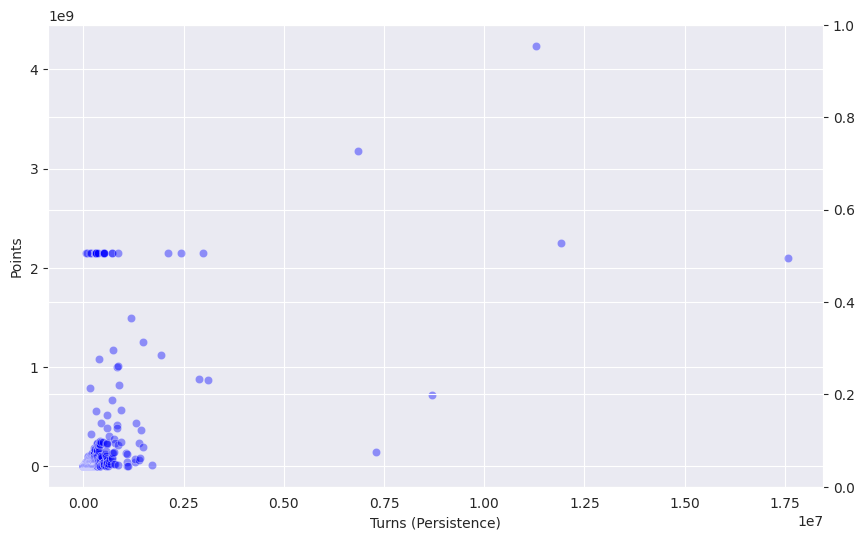

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import db  # Assuming you have the db module for handling database interactions

# Function to get turns and points data from the dataset
def get_persistence_stats(dataset_name, dbfilename=db.DB):
    """
    Retrieves the number of turns played and the points scored from the dataset.
    
    Parameters:
    - dataset_name: Name of the dataset (e.g., 'nld-nao').
    - dbfilename: Path to the SQLite database file.
    
    Returns:
    - pd.DataFrame: A DataFrame with gameid, turns, points, and maxlvl.
    """
    sql_args = (dataset_name,)

    sql = """
    SELECT games.gameid, games.turns, games.points, games.maxlvl
    FROM games
    INNER JOIN datasets ON games.gameid=datasets.gameid
    WHERE datasets.dataset_name=?"""
    
    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        stats = pd.DataFrame(data, columns=["gameid", "turns", "points", "maxlvl"])
    return stats

# Visualization: Relationship between Turns (Persistence) and Points
def plot_persistence_vs_points(dataset_name, dbfilename=db.DB):
    """
    Plots the relationship between persistence (turns played) and points scored.
    
    Parameters:
    - dataset_name: Name of the dataset (e.g., 'nld-nao').
    - dbfilename: Path to the SQLite database file.
    
    Returns:
    - None (displays the plot).
    """
    # Get the persistence stats (turns and points)
    df = get_persistence_stats(dataset_name, dbfilename)

    # Sort data by the number of turns played
    df = df.sort_values(by="turns")

    # Plot turns vs points using seaborn and matplotlib
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Create scatterplot for turns vs points
    sns.scatterplot(data=df, x="turns", y="points", ax=ax1, color="blue", alpha=0.4)
    ax1.set_xlabel("Turns (Persistence)")
    ax1.set_ylabel("Points")
    
    # Plot the rolling mean of points for visualization of persistence trend
    df['rolling_mean_points'] = df['points'].rolling(window=100).mean()
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x="turns", y="rolling_mean_points", ax=ax2, color="red")
    ax2.set_ylabel("Rolling Mean of Points")
    
    # Add title and display the plot
    plt.title(f"Persistence vs. Points in {dataset_name} Dataset")
    plt.show()

# Example usage with print function (Python 3 syntax)
if __name__ == "__main__":
    print("Plotting persistence vs points...")
    plot_persistence_vs_points("nld-nao", dbfilename)



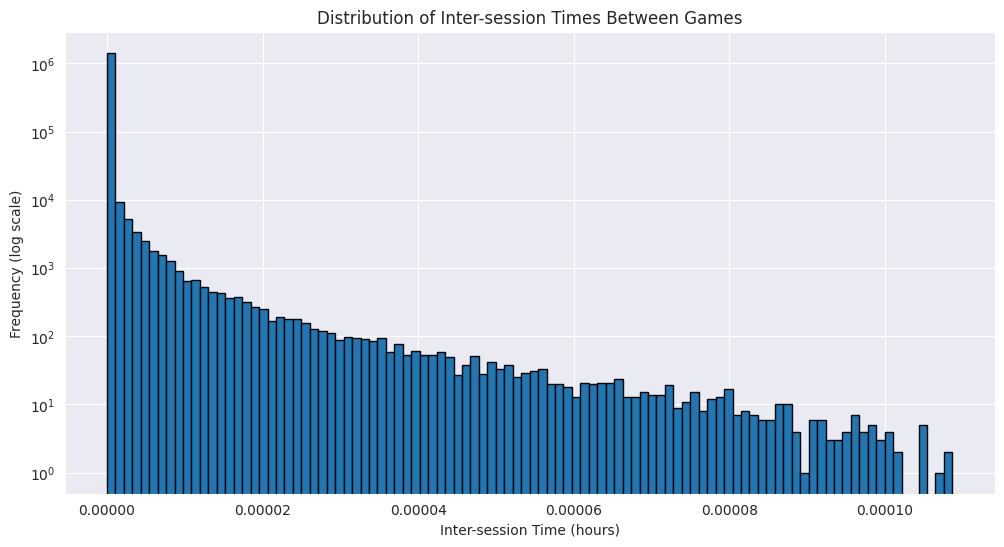

In [10]:
def get_inter_session_times(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)
    
    sql = """
    SELECT games.gameid, games.name, games.starttime
    FROM games
    INNER JOIN datasets ON games.gameid = datasets.gameid
    WHERE datasets.dataset_name=?
    ORDER BY games.name, games.starttime
    """

    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        df = pd.DataFrame(data, columns=["gameid", "name", "starttime"])
    return df


# Retrieve inter-session times
df = get_inter_session_times(dataset_name, dbfilename)

# Convert 'starttime' to datetime
df['starttime'] = pd.to_datetime(df['starttime'])

# Sort by 'name' and 'starttime'
df = df.sort_values(['name', 'starttime'])

# Compute inter-session times per player in hours
df['inter_session_time'] = df.groupby('name')['starttime'].diff().dt.total_seconds() / 3600

# Remove NaN values (first game per player)
inter_session_times = df['inter_session_time'].dropna()

# Plot the distribution of inter-session times
plt.figure(figsize=(12, 6))
plt.hist(inter_session_times, bins=100, log=True, edgecolor='black')
plt.xlabel('Inter-session Time (hours)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Inter-session Times Between Games')
plt.grid(True)
plt.show()

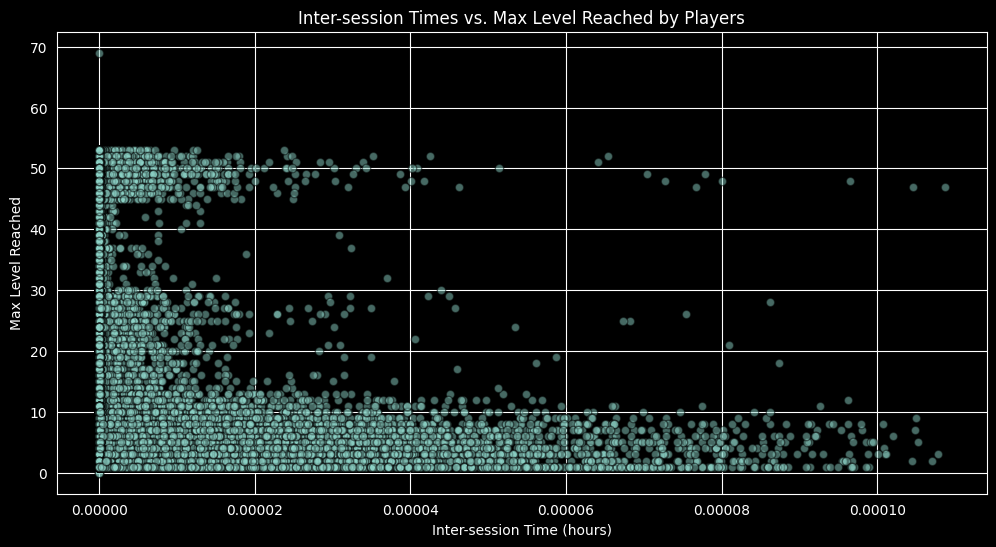

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
# import db  # Assuming you have a module for database connection

def get_inter_session_times_with_maxlvl(dataset_name, dbfilename):
    """
    Retrieves inter-session times and max levels reached by players.
    
    Parameters:
    - dataset_name (str): Name of the dataset.
    - dbfilename (str): Path to the SQLite database file.
    
    Returns:
    - pd.DataFrame: DataFrame with gameid, name, starttime, maxlvl, and inter-session times.
    """
    sql_args = (dataset_name,)
    
    sql = """
    SELECT games.gameid, games.name, games.starttime, games.maxlvl
    FROM games
    INNER JOIN datasets ON games.gameid = datasets.gameid
    WHERE datasets.dataset_name=?
    ORDER BY games.name, games.starttime
    """

    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        df = pd.DataFrame(data, columns=["gameid", "name", "starttime", "maxlvl"])
    
    # Convert 'starttime' to datetime
    df['starttime'] = pd.to_datetime(df['starttime'])

    # Sort by 'name' and 'starttime'
    df = df.sort_values(['name', 'starttime'])

    # Compute inter-session times per player in hours
    df['inter_session_time'] = df.groupby('name')['starttime'].diff().dt.total_seconds() / 3600

    # Remove NaN values (first game per player)
    df = df.dropna(subset=['inter_session_time'])

    return df

# Retrieve inter-session times and max levels
df = get_inter_session_times_with_maxlvl(dataset_name, dbfilename)

# Plot inter-session times against max level
plt.figure(figsize=(12, 6))
plt.scatter(df['inter_session_time'], df['maxlvl'], alpha=0.5, edgecolor='k')
plt.xlabel('Inter-session Time (hours)')
plt.ylabel('Max Level Reached')
plt.title('Inter-session Times vs. Max Level Reached by Players')
plt.grid(True)
plt.show()

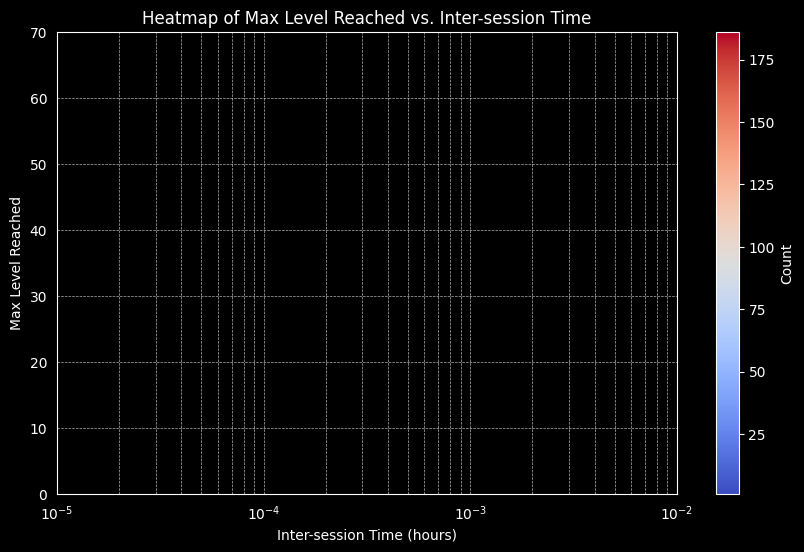

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure your DataFrame is populated correctly with meaningful values
# Filter out any extreme or irrelevant values if needed
filtered_df = df[(df['inter_session_time'] > 1e-5) & (df['inter_session_time'] < 1e-2) & (df['maxlvl'] > 0)]

# Plot the heatmap with refined parameters
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    filtered_df['inter_session_time'], 
    filtered_df['maxlvl'], 
    gridsize=50, 
    cmap='coolwarm', 
    mincnt=1
)

# Log scale on x-axis if values are small
plt.xscale('log')

# Add color bar and labels
cb = plt.colorbar(hb)
cb.set_label('Count')
plt.xlabel('Inter-session Time (hours)')
plt.ylabel('Max Level Reached')
plt.title('Heatmap of Max Level Reached vs. Inter-session Time')

# Set x and y axis limits if data is concentrated in a specific range
plt.xlim(1e-5, 1e-2)
plt.ylim(0, 70)

plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


Filtered data shape: (7251, 5)
Inter-session time min: 1.0002080555555556e-05
Inter-session time max: 0.00010865653222222222
Max level min: 1
Max level max: 53


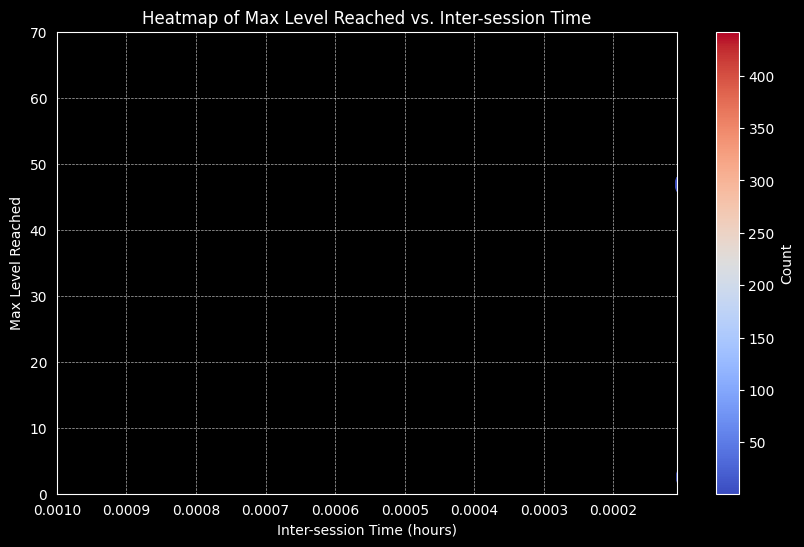

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure DataFrame has valid values
filtered_df = df[(df['inter_session_time'] > 1e-5) & (df['inter_session_time'] < 1e-2) & (df['maxlvl'] > 0)]

# Check the data ranges
print("Filtered data shape:", filtered_df.shape)
print("Inter-session time min:", filtered_df['inter_session_time'].min())
print("Inter-session time max:", filtered_df['inter_session_time'].max())
print("Max level min:", filtered_df['maxlvl'].min())
print("Max level max:", filtered_df['maxlvl'].max())

# Plot the heatmap with refined parameters
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    filtered_df['inter_session_time'], 
    filtered_df['maxlvl'], 
    gridsize=30,  # Adjusted gridsize
    cmap='coolwarm', 
    mincnt=1
)

# Comment out log scale to check if data appears without it
# plt.xscale('log')

# Add color bar and labels
cb = plt.colorbar(hb)
cb.set_label('Count')
plt.xlabel('Inter-session Time (hours)')
plt.ylabel('Max Level Reached')
plt.title('Heatmap of Max Level Reached vs. Inter-session Time')

# Adjust x and y limits based on data range
plt.xlim(1e-3, filtered_df['inter_session_time'].max())
plt.ylim(0, 70)

plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


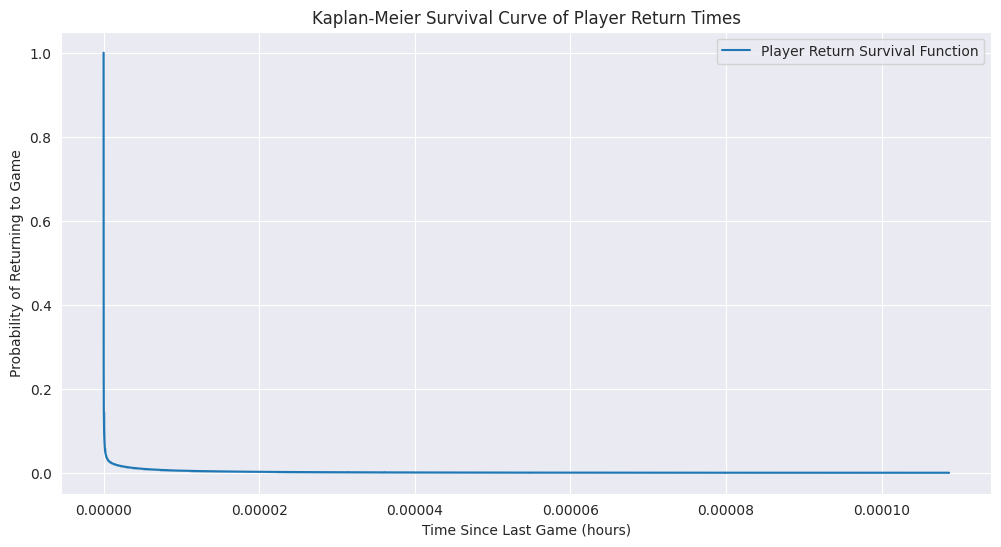

In [24]:
from lifelines import KaplanMeierFitter

# Prepare data for survival analysis
T = inter_session_times  # Time until next event (inter-session time)
E = np.ones_like(T)      # Event occurred (player returned)

# Create a Kaplan-Meier fitter instance
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(T, event_observed=E, label='Player Return Survival Function')

# Plot the survival function
plt.figure(figsize=(12, 6))
kmf.plot()
plt.xlabel('Time Since Last Game (hours)')
plt.ylabel('Probability of Returning to Game')
plt.title('Kaplan-Meier Survival Curve of Player Return Times')
plt.grid(True)
plt.show()

/tmp/ipykernel_37520/3866889245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['game_number'] = df_clean.groupby('name').cumcount() + 1
/tmp/ipykernel_37520/3866889245.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_clean, x='game_number', y='inter_session_time', estimator='mean', ci='sd')


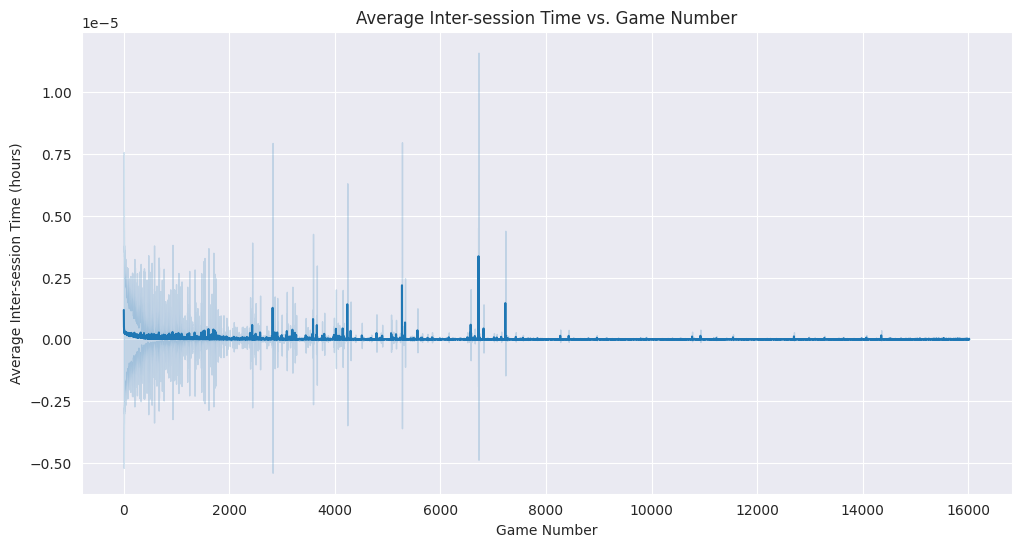

In [26]:
# Merge inter-session times back into the original DataFrame
df['inter_session_time'] = df.groupby('name')['starttime'].diff().dt.total_seconds() / 3600

# Remove NaN values
df_clean = df.dropna(subset=['inter_session_time'])

# Assign game numbers
df_clean['game_number'] = df_clean.groupby('name').cumcount() + 1

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, x='game_number', y='inter_session_time', estimator='mean', ci='sd')
plt.xlabel('Game Number')
plt.ylabel('Average Inter-session Time (hours)')
plt.title('Average Inter-session Time vs. Game Number')
plt.grid(True)
plt.show()

In [12]:
batch_idx = 3
time_idx = 21

# Observation Example and Corresponding Metadata

chars = minibatch['tty_chars'][batch_idx, time_idx]
colors = minibatch['tty_colors'][batch_idx, time_idx]
cursor = minibatch['tty_cursor'][batch_idx, time_idx]

game_id = minibatch['gameids'][batch_idx, time_idx]

print(tty_render(chars, colors, cursor))

dict(dataset.get_meta(game_id))


{'gameid': 3771998,
 'version': '3.4.3',
 'points': 879,
 'deathdnum': 0,
 'deathlev': 4,
 'maxlvl': 5,
 'hp': 0,
 'maxhp': 31,
 'deaths': 1,
 'deathdate': 20090418,
 'birthdate': 20090418,
 'uid': 5,
 'role': 'Wiz',
 'race': 'Hum',
 'gender': 'Mal',
 'align': 'Neu',
 'name': 'Player44172',
 'death': 'killed by an imp',
 'conduct': '0xf88',
 'turns': 1258,
 'achieve': '0x0',
 'realtime': 1182,
 'starttime': 1240047910,
 'endtime': 1240049103,
 'gender0': 'Mal',
 'align0': 'Neu',
 'flags': '-1'}

In [13]:
# Build the subselect sql query 
# The usefuleness of this inquiry is due to the fact that certain builds are easier and have a higher probability of success 
# This can be confirmed statistically
# TODO: Get Stats and Visualization of builds and success

subselect_sql = "SELECT gameid FROM games WHERE role=? AND race=?"
subselect_sql_args = ("Mon", "Hum")

batch_size = 10

# Build the dataset
monk_dataset = nld.TtyrecDataset(
    "nld-nao",
    batch_size=batch_size,
    seq_length=32,
    dbfilename=dbfilename,
    subselect_sql=subselect_sql,
    subselect_sql_args=subselect_sql_args
)

# No Error found - Correct build 
print(f"Human Monk Subdataset Has: {len(monk_dataset._gameids)}")

mb = next(iter(monk_dataset))
    
batch_idx = 1
time_idx = 21
chars = mb['tty_chars'][batch_idx, time_idx]
colors = mb['tty_colors'][batch_idx, time_idx]
cursor = mb['tty_cursor'][batch_idx, time_idx]

print(tty_render(chars, colors, cursor))

Human Monk Subdataset Has: 84071

                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                           

In [14]:
# Build the subselect sql query
subselect_sql = "SELECT gameid FROM games WHERE death = ?"
subselect_sql_args = ("ascended",)

# Build the dataset
ascended_dataset = nld.TtyrecDataset(
    "nld-nao",
    batch_size=10,
    seq_length=32,
    dbfilename=dbfilename,
    subselect_sql=subselect_sql,
    subselect_sql_args=subselect_sql_args
)

# See from the error how there are fewer than 10k games despite the full dataset having 109k
print(f"Ascended Player Dataset Has: {len(ascended_dataset._gameids)}")

# mb = next(iter(ascended_dataset))
# 
# batch_idx = 1
# time_idx = 18
# chars = mb['tty_chars'][batch_idx, time_idx]
# colors = mb['tty_colors'][batch_idx, time_idx]
# cursor = mb['tty_cursor'][batch_idx, time_idx]
# 
# print(tty_render(chars, colors, cursor))


# Convert to DataFrame
df = pd.DataFrame(ascended_dataset)

# Dask Experiment - Current status: too slow
import dask.dataframe as dd

dask_df = dd.from_pandas(pd.DataFrame(ascended_dataset), npartitions=4)

# Group by time and count the number of games
result = dask_df.groupby('time').size().compute()

# Plotting
result.plot(kind='line')
plt.xlabel('Time')
plt.ylabel('Number of Games')
plt.title('Number of Games Over Time')
plt.show()


Ascended Player Dataset Has: 22071


KeyboardInterrupt: 

In [15]:
# Define a dataset with all the games for every player who has ascended at least once

subselect_sql = """
SELECT *
FROM games
WHERE name IN (SELECT DISTINCT name FROM games WHERE death = 'ascended')
"""

df = pd.read_sql(subselect_sql, db_conn) 

column_to_move = 'name'

new_columns_order = [column_to_move] + [col for col in df.columns if col != column_to_move]

# Reorder the dataframe columns
df = df[new_columns_order] 

# Sorting by the 'name' column
df = df.sort_values(by='name')

# midpoint = len(df) // 2 
# 
# # Split the dataframe into two smaller dataframes
# df1 = df.iloc[:midpoint].reset_index(drop=True)
# print(df1.head())


killed by a soldier ant


Text(0.5, 0, 'death')

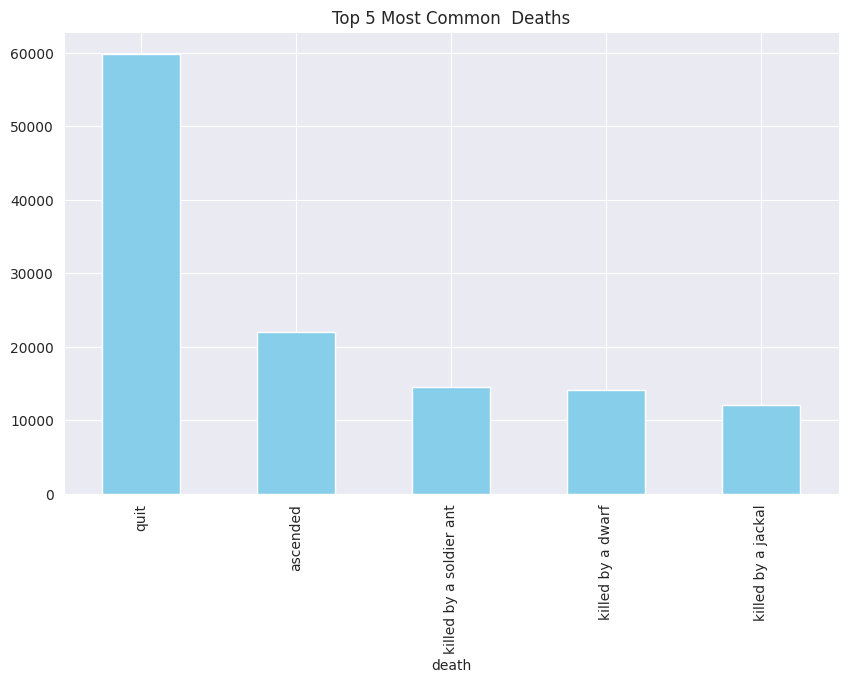

In [16]:
# Sorting by the 'name' column
df = df.sort_values(by='name')

value_counts = df['death'].value_counts()
if len(value_counts) > 1:
    print(value_counts.index[2])
else:
    print("Try again")

# Top five most common deaths (quit and ascended are less interesting) 
top_five = df['death'].value_counts().nlargest(5)

# Plot the frequencies
plt.figure(figsize=(10, 6))
top_five.plot(kind='bar', color='skyblue')
plt.title(f'Top 5 Most Common  Deaths')
plt.xlabel('death')

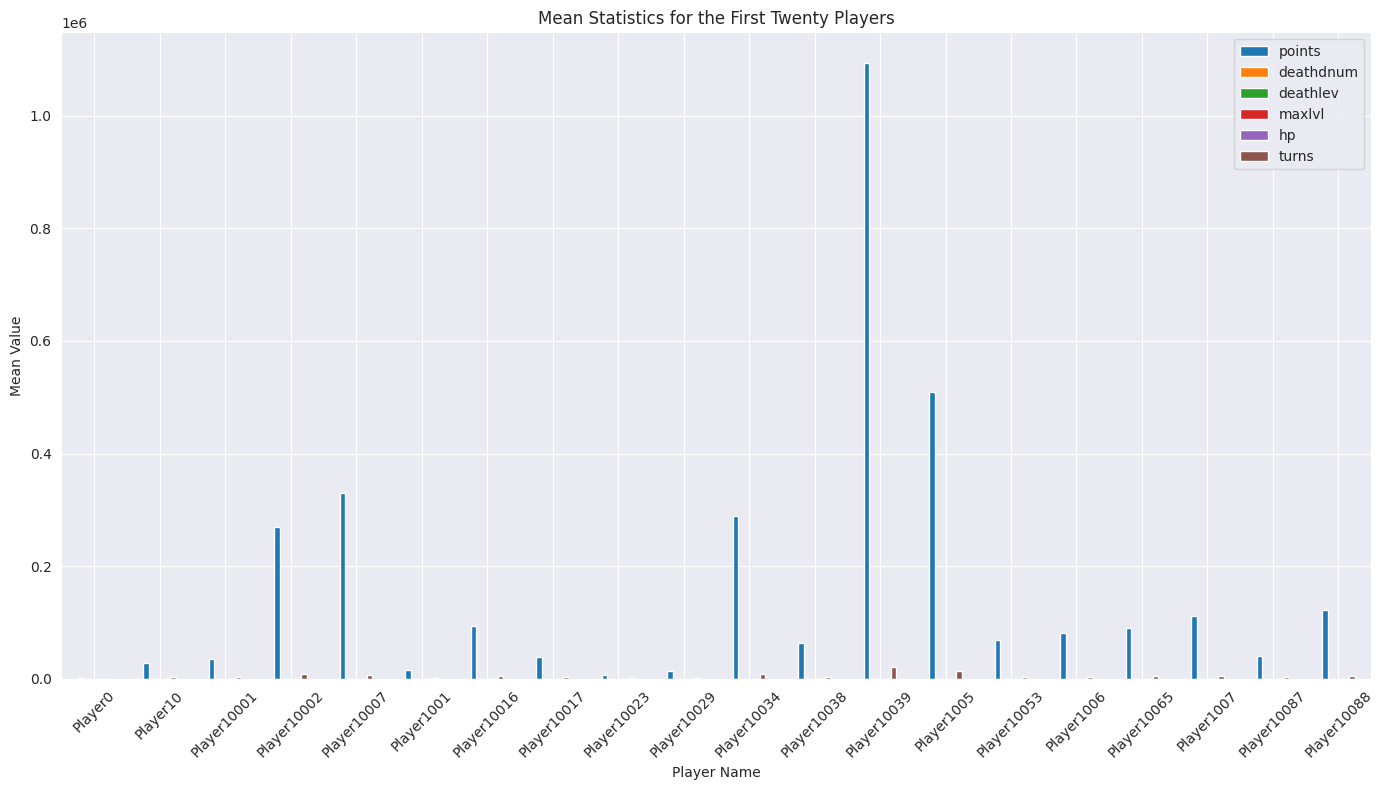

In [17]:

# Group by
grouped = df.groupby('name')

# Player Statistics
stats = grouped.agg({
    'points': ['mean', 'min', 'max'],
    'deathdnum': ['mean', 'min', 'max'],
    'deathlev': ['mean', 'min', 'max'],
    'maxlvl': ['mean', 'min', 'max'],
    'hp': ['mean', 'min', 'max'],
    'turns': ['mean', 'min', 'max']
})


# Extract mean values for each statistic
mean_stats = stats.xs('mean', axis=1, level=1)

# Limit to the first twenty players
top20 = mean_stats.head(20)

# Plot the mean values for the first twenty players
# TODO: Fix scale of graph 

top20.plot(kind='bar', figsize=(14, 8))
plt.title('Mean Statistics for the First Twenty Players')
plt.xlabel('Player Name')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [ ]:
# Create a separate plot for each statistic
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Points statistics
axs[0, 0].bar(stats.index, stats[('points', 'mean')], color='blue')
axs[0, 0].set_title('Max Points by Player')
axs[0, 0].set_ylabel('Max Points')

# axs[0, 1].bar(stats.index, stats[('points', 'mean')], color='green')
# axs[0, 1].set_title('Average Points by Player')
# axs[0, 1].set_ylabel('Average Points')

# # Deathdnum statistics
# axs[1, 0].bar(stats.index, stats[('deathdnum', 'sum')], color='blue')
# axs[1, 0].set_title('Total Deathdnum by Player')
# axs[1, 0].set_ylabel('Total Deathdnum')
# 
# axs[1, 1].bar(stats.index, stats[('deathdnum', 'mean')], color='green')
# axs[1, 1].set_title('Average Deathdnum by Player')
# axs[1, 1].set_ylabel('Average Deathdnum')
# 
# # MaxLvL statistics
# axs[2, 0].bar(stats.index, stats[('maxLvL', 'sum')], color='blue')
# axs[2, 0].set_title('Total MaxLvL by Player')
# axs[2, 0].set_ylabel('Total MaxLvL')
# 
# axs[2, 1].bar(stats.index, stats[('maxLvL', 'mean')], color='green')
# axs[2, 1].set_title('Average MaxLvL by Player')
# axs[2, 1].set_ylabel('Average MaxLvL')

# Layout adjustments
plt.tight_layout()

# Display the plots
plt.show()

In [20]:
# Ascended Stats Function
# TODO: Fix function

def ascended_stats(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)

    sql = """
    SELECT *
    FROM games
    WHERE name IN (SELECT DISTINCT name FROM games WHERE death = 'ascended')
    """
    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        stats = pd.DataFrame(data, columns=["gameid", "points", "turns", "maxlvl"])
    return stats

# Testing
test = ascended_stats("nld-nao", dbfilename) 

print(test)

ProgrammingError: Incorrect number of bindings supplied. The current statement uses 0, and there are 1 supplied.

KeyError: 'points_min'

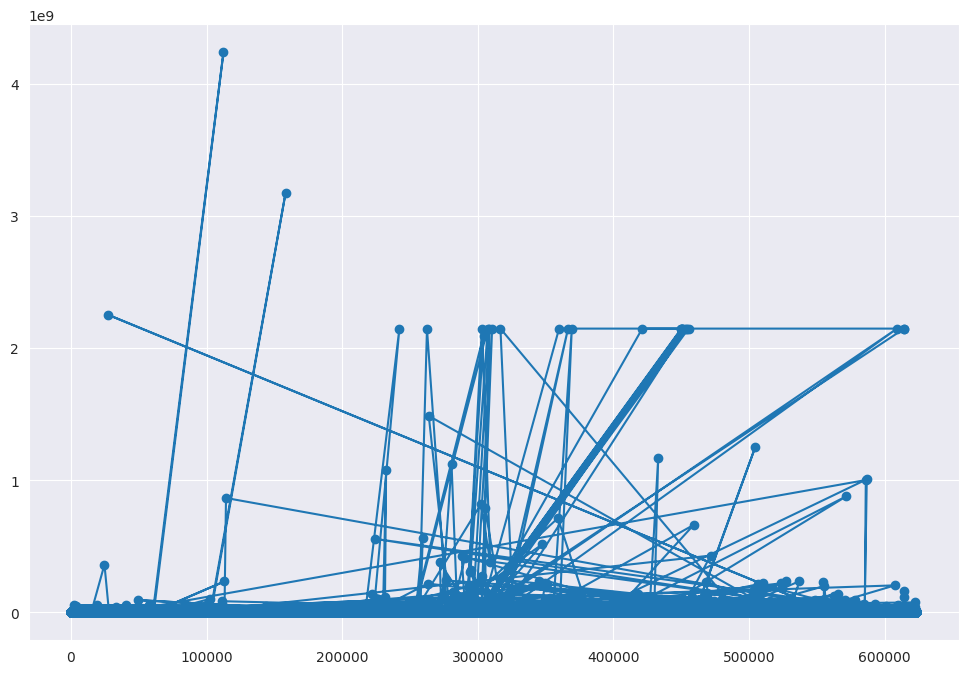

In [19]:
# Create a plot for the points statistics
plt.figure(figsize=(12, 8))

# Plot mean points
plt.plot(df.index, df['points'], label='Mean Points', marker='o')

# Plot min points
plt.plot(df.index, df['points_min'], label='Min Points', marker='o')

# Plot max points
plt.plot(df.index, df['points_max'], label='Max Points', marker='o')

# Add titles and labels
plt.title('Player Points Statistics')
plt.xlabel('Player')
plt.ylabel('Points')
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

name
Player25097    584
Player41611    531
Player558      376
Player924      341
Player55533    257
Player503      250
Player48483    248
Player937      248
Player16893    236
Player1092     206
Name: count, dtype: int64
               name   gameid version   points  deathdnum  deathlev  maxlvl  \
215115      Player0  3521212   3.4.3        5          7        -5       1   
8473       Player10    59553   3.6.4  3851020          7        -5      51   
36801      Player10  1747420   3.6.2  2828778          7        -5      47   
488325  Player10001  5643063   3.4.3  4626262          7        -5      51   
511684  Player10001  5795712   3.4.3  3385862          7        -5      49   
...             ...      ...     ...      ...        ...       ...     ...   
219882   Player9975  3539827   3.4.3  3058852          7        -5      51   
5037      Player998    39460   3.6.4  6267368          7        -5      52   
285194   Player9992  3824651   3.4.3  5250980          7        -5      49   

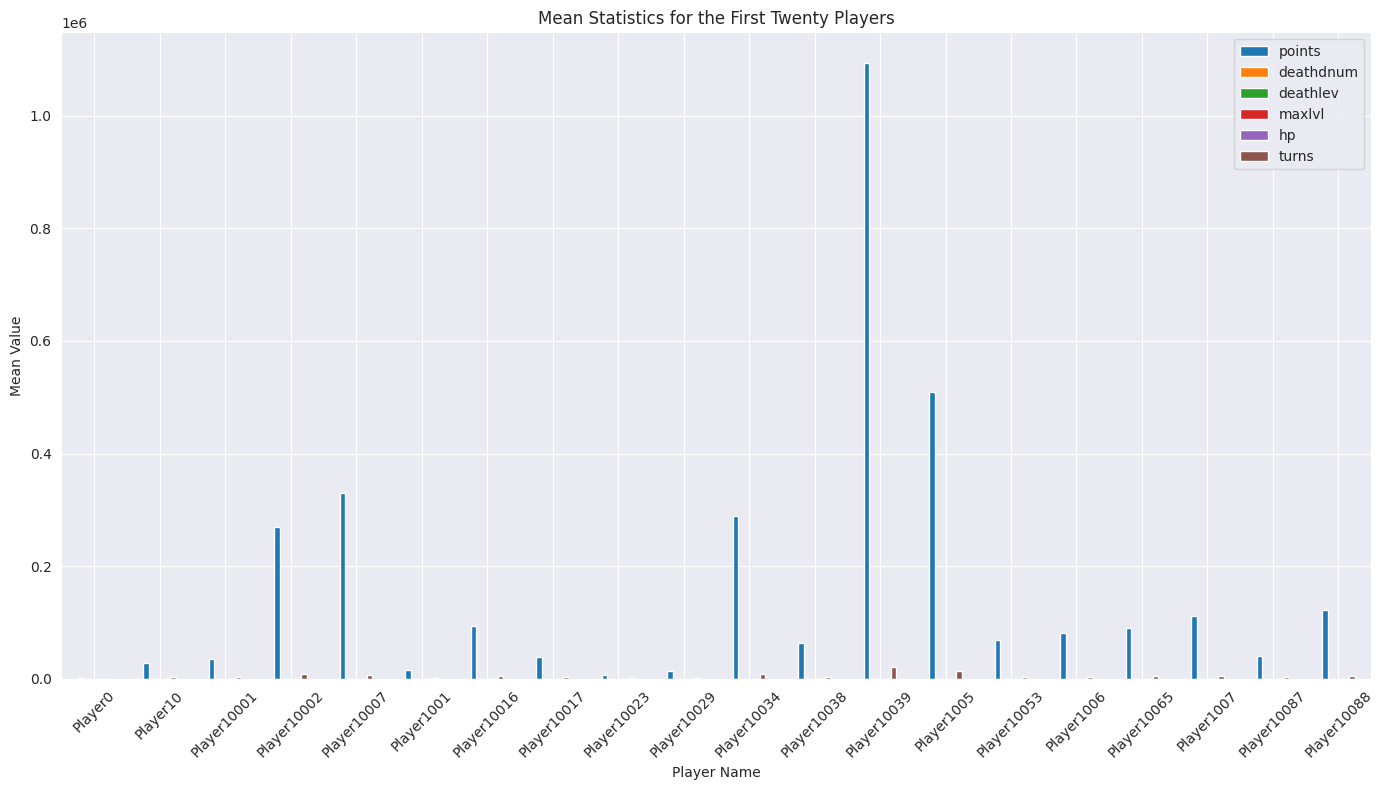

In [21]:
# TODO: Implement NeurIPS insights 

# Players with most ascensions
# Filter the DataFrame to include only rows where 'death' is 'ascended'
ascended_df = df[df['death'] == 'ascended']

# Count the number of ascensions for each player
ascension_counts = ascended_df['name'].value_counts()

# Display the players with the most ascensions
print(ascension_counts.head(10))  # Display top 10 players

# Get the top 10 players with the most ascensions
top_10_players = ascension_counts.head(10) 

print(ascended_df)




# Group by 
grouped = df.groupby('name')

# Player Statistics
stats = grouped.agg({
    'points': ['mean', 'min', 'max'],
    'deathdnum': ['mean', 'min', 'max'],
    'deathlev': ['mean', 'min', 'max'],
    'maxlvl': ['mean', 'min', 'max'],
    'hp': ['mean', 'min', 'max'],
    'turns': ['mean', 'min', 'max']
})


# Extract mean values for each statistic
mean_stats = stats.xs('mean', axis=1, level=1)

# Limit to the first twenty players
top20 = mean_stats.head(20)

# Plot the mean values for the first twenty players
# TODO: Fix scale of graph 

top20.plot(kind='bar', figsize=(14, 8))
plt.title('Mean Statistics for the First Twenty Players')
plt.xlabel('Player Name')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [22]:
"""WITH PointsChange AS (SELECT name, gameid, points, starttime, LEAD(points) OVER (PARTITION BY name ORDER BY starttime) - points AS points_diff FROM games)"""
"""WITH UpwardTrend AS (SELECT name, COUNT(CASE WHEN points_diff > 0 THEN 1 END) AS positive_diff_count, COUNT(*) AS total_games FROM PointsChange GROUP BY name)"""

sql = """SELECT name FROM UpwardTrend WHERE positive_diff_count >= (total_games * 0.8)""" 

df = pd.read_sql(sql, db_conn)  
df

DatabaseError: Execution failed on sql 'SELECT name FROM UpwardTrend WHERE positive_diff_count >= (total_games * 0.8)': no such table: UpwardTrend

In [23]:

maxlvl_increase_sql = """
WITH LevelChange AS (
    SELECT 
        name,
        gameid,
        maxlvl,
        starttime,
        LEAD(maxlvl) OVER (PARTITION BY name ORDER BY starttime) - maxlvl AS level_diff
    FROM games
),

UpwardTrend AS (
    SELECT
        name,
        COUNT(CASE WHEN level_diff > 0 THEN 1 END) AS positive_diff_count,
        COUNT(CASE WHEN level_diff < 0 THEN 1 END) AS negative_diff_count,
        COUNT(*) AS total_games
    FROM LevelChange
    GROUP BY name
)

SELECT 
    *,
    positive_diff_count,
    negative_diff_count,
    total_games
FROM UpwardTrend
WHERE positive_diff_count >= (total_games * 0.65)   
ORDER BY positive_diff_count DESC;
"""

# Execute the query and load the data into a pandas DataFrame
data = pd.read_sql_query(maxlvl_increase_sql, db_conn)

data

,name,positive_diff_count,negative_diff_count,total_games,positive_diff_count,negative_diff_count,total_games
0,Player1377,8,3,12,8,3,12
1,Player3782,8,2,12,8,2,12
2,Player36725,7,2,10,7,2,10
3,Player13575,6,2,9,6,2,9
4,Player39784,6,2,9,6,2,9
...,...,...,...,...,...,...,...
437,Player9118,2,0,3,2,0,3
438,Player9194,2,0,3,2,0,3
439,Player9226,2,0,3,2,0,3
440,Player9320,2,0,3,2,0,3


In [24]:
maxlvl_increase_sql = """
WITH LevelChange AS (
    SELECT 
        name,
        gameid,
        maxlvl,
        starttime,
        LEAD(maxlvl) OVER (PARTITION BY name ORDER BY starttime) - maxlvl AS level_diff
    FROM games
),

UpwardTrend AS (
    SELECT
        name,
        COUNT(CASE WHEN level_diff > 0 THEN 1 END) AS positive_diff_count,
        COUNT(CASE WHEN level_diff < 0 THEN 1 END) AS negative_diff_count,
        COUNT(*) AS total_games
    FROM LevelChange
    GROUP BY name
    HAVING COUNT(CASE WHEN level_diff > 0 THEN 1 END) >= (COUNT(*) * 0.65)  -- Players with an upward trend in at least 80% of their games
)

SELECT 
    g.*
FROM
    games g
JOIN
    UpwardTrend ut ON g.name = ut.name
ORDER BY
    g.name, g.starttime
"""

# Execute the query and load the data into a pandas DataFrame
data = pd.read_sql_query(maxlvl_increase_sql, db_conn)
data

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,death,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags
0,1905856,3.6.1,89,0,1,1,12,12,0,20161111,...,escaped,0xfcf,170,0x0,8228,1478825086,1478834428,Fem,Neu,0x4
1,1905857,3.6.1,166,0,2,2,0,13,1,20161111,...,killed by a jackal,0xfcf,476,0x0,610,1478834625,1478835240,Fem,Cha,0x4
2,1905858,3.6.1,655,2,3,3,-1,25,1,20161111,...,killed by a crossbow bolt,0xfdf,605,0x0,888,1478835301,1478836259,Mal,Cha,0x4
3,40057,3.6.4,5,0,1,1,12,12,0,20200124,...,quit,0xfff,75,0x0,7758,1579782302,1579896280,Mal,Cha,0x4
4,40060,3.6.4,89,0,2,2,0,12,1,20200124,...,killed by a goblin,0xfc8,365,0x0,307,1579896301,1579896609,Mal,Cha,0x4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,1871049,3.6.3,211,0,2,3,19,19,0,20191101,...,quit,0xf88,1089,0x0,1734,1572575408,1572577145,Mal,Neu,0x4
1584,1871076,3.6.3,2293,2,5,6,0,38,1,20191101,...,killed by a gnome mummy while praying,0xf80,2771,0x0,5424,1572577190,1572582689,Mal,Neu,0x4
1585,1871086,3.6.3,666,0,7,7,0,22,1,20191101,...,killed by a homunculus,0xf88,836,0x0,849,1572583272,1572584123,Mal,Neu,0x4
1586,1871088,3.6.3,283,0,5,5,0,15,1,20191101,...,killed by a water moccasin,0xfc8,527,0x0,503,1572584213,1572584717,Mal,Neu,0x4


In [43]:
# Randomly sample 100 players and all their corresponding games
random_sample = """
WITH PlayersOver100Games AS (
    SELECT 
        name
    FROM 
        games
    GROUP BY 
        name
    HAVING 
        COUNT(*) > 300
)

SELECT 
    *
FROM 
    games
WHERE 
    name IN (SELECT name FROM PlayersOver100Games)
ORDER BY 
    name, starttime;
"""

# Execute the query and load the data into a pandas DataFrame
data = pd.read_sql_query(random_sample, db_conn)

data = data.sort_values(by=['name','starttime'])
# Convert Unix time columns to human-readable datetime
data['starttime'] = pd.to_datetime(data['starttime'], unit='s')
data['endtime'] = pd.to_datetime(data['endtime'], unit='s')
data

,gameid,version,points,deathdnum,deathlev,maxlvl,hp,maxhp,deaths,deathdate,...,death,conduct,turns,achieve,realtime,starttime,endtime,gender0,align0,flags
0,4085412,3.4.3,2091,2,4,4,0,32,1,20100730,...,killed by a dwarf,0xfc8,1152,0x0,2308,2010-07-30 08:23:27,2010-07-30 09:02:23,Fem,Cha,-1
1,4086650,3.4.3,144,0,2,3,-17,14,1,20100731,...,"killed by a guard, while sleeping",0xfc8,299,0x0,851,2010-07-30 09:02:50,2010-07-31 17:39:29,Fem,Cha,-1
2,4086653,3.4.3,0,0,1,1,-1,14,1,20100731,...,killed by a water demon,0xfff,6,0x0,50,2010-07-31 17:39:41,2010-07-31 17:40:35,Fem,Cha,-1
3,4086664,3.4.3,1806,2,5,5,0,32,1,20100731,...,killed by a housecat,0xfc0,2226,0x0,2288,2010-07-31 17:40:43,2010-07-31 18:18:57,Fem,Cha,-1
4,4086668,3.4.3,190,0,1,2,0,14,1,20100731,...,killed by a fox,0xfc8,448,0x0,309,2010-07-31 18:19:02,2010-07-31 18:24:20,Fem,Cha,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726784,1902415,3.6.3,132,0,2,2,0,15,1,20200911,...,killed by a sewer rat,0xf88,404,0x0,168,2020-09-11 19:54:40,2020-09-11 19:57:29,Mal,Law,0x4
726785,1902434,3.6.3,4507,2,7,10,0,65,1,20200916,...,killed by a jaguar while reading a book,0xf80,4729,0x0,2573,2020-09-14 23:41:24,2020-09-16 00:28:49,Mal,Law,0x0
726786,1902489,3.6.3,42,0,1,1,0,15,1,20200929,...,killed by a bear trap,0xf8f,179,0x0,62,2020-09-29 17:14:36,2020-09-29 17:15:39,Mal,Law,0x4
726787,1903284,3.6.3,2333,2,8,8,0,58,1,20201022,...,killed by a killer bee,0xf80,2913,0x0,8501,2020-10-18 23:17:07,2020-10-22 19:18:21,Mal,Law,0x4


In [39]:
data['cumulative_points'] = data.groupby('name')['points'].cumsum()
sns.lineplot(x='starttime', y='cumulative_points', hue='name', data=data)
plt.title('Cumulative Points Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Points')
plt.show()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x719ee15bcb80> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x719ef8771a20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
import seaborn as sns

# Set a seaborn style
sns.set(style="whitegrid")

# Plot for each player
for name, group in grouped:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Player: {name}", fontsize=16)

    # Points over Time
    sns.lineplot(ax=axes[0, 0], x='starttime', y='points', data=group, marker='o')
    axes[0, 0].set_title('Points Over Time')

    # Maxlvl over Time
    sns.lineplot(ax=axes[0, 1], x='starttime', y='maxlvl', data=group, marker='o', color='orange')
    axes[0, 1].set_title('Max Level Over Time')

    # Turns over Time
    sns.lineplot(ax=axes[1, 0], x='starttime', y='turns', data=group, marker='o', color='green')
    axes[1, 0].set_title('Turns Over Time')

    # MaxHP over Time
    sns.lineplot(ax=axes[1, 1], x='starttime', y='maxhp', data=group, marker='o', color='red')
    axes[1, 1].set_title('Max HP Over Time')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['points', 'maxlvl', 'turns', 'maxhp']

# Fit and transform the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Display the normalized data
print(data.head())

    gameid version    points  deathdnum  deathlev    maxlvl  hp     maxhp  \
0  3790133   3.4.3  0.003913          4         6  0.173077 -15  0.142077   
1  3790458   3.4.3  0.000062          0         2  0.019231   0  0.036430   
2  3793827   3.4.3  0.000095          0         3  0.057692  20  0.034608   
3  3794284   3.4.3  0.000259          0         2  0.038462  -3  0.069217   
4  3795891   3.4.3  0.002379          0         9  0.173077   0  0.109290   

   deaths  deathdate  ...  conduct     turns achieve realtime  \
0       1   20090517  ...    0xf80  0.091672     0x0    25382   
1       1   20090518  ...    0xf88  0.007746     0x0      994   
2       1   20090523  ...    0xf80  0.011044     0x0    65296   
3       1   20090524  ...    0xf86  0.007761     0x0     2066   
4       1   20090527  ...    0xf80  0.049866     0x0    10547   

            starttime             endtime gender0 align0 flags  \
0 2009-03-10 14:12:45 2009-05-17 22:50:05     Fem    Cha    -1   
1 2009-05-18 1

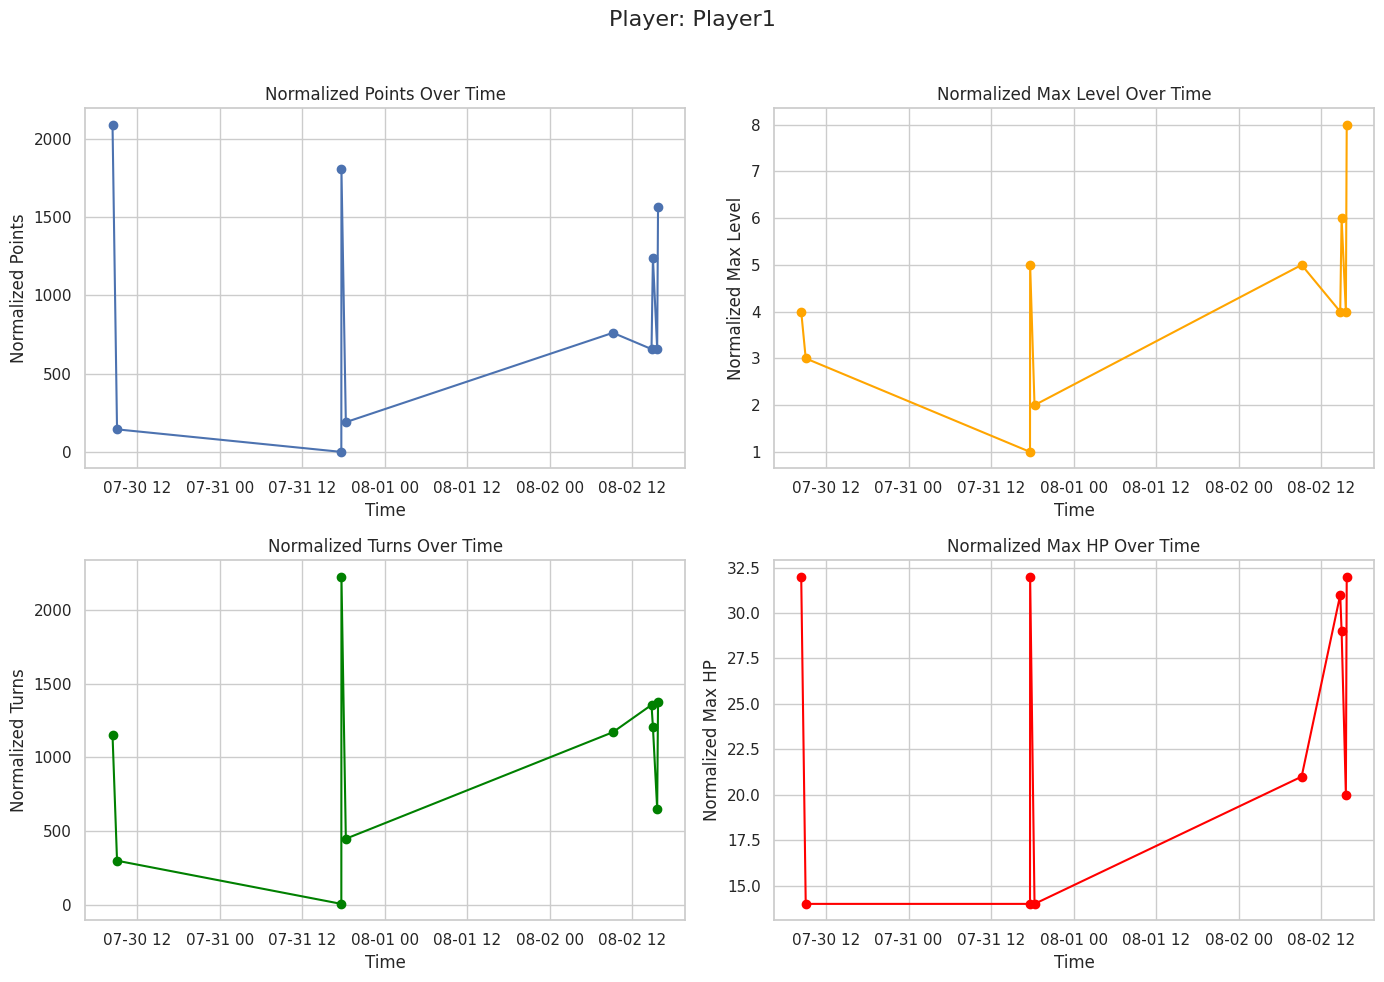

In [42]:
data = data[0:1000]
grouped = data.groupby('name')

# Plot for each player
for name, group in grouped:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Player: {name}", fontsize=16)

    # Plot Points over Time
    axes[0, 0].plot(group['starttime'], group['points'], marker='o')
    axes[0, 0].set_title('Normalized Points Over Time')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Normalized Points')

    # Plot Maxlvl over Time
    axes[0, 1].plot(group['starttime'], group['maxlvl'], marker='o', color='orange')
    axes[0, 1].set_title('Normalized Max Level Over Time')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Normalized Max Level')

    # Plot Turns over Time
    axes[1, 0].plot(group['starttime'], group['turns'], marker='o', color='green')
    axes[1, 0].set_title('Normalized Turns Over Time')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Normalized Turns')

    # Plot MaxHP over Time
    axes[1, 1].plot(group['starttime'], group['maxhp'], marker='o', color='red')
    axes[1, 1].set_title('Normalized Max HP Over Time')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Normalized Max HP')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [48]:
max_non_ascended_sql = """
WITH NonAscendedGames AS (
    SELECT 
        name,
        COUNT(*) AS non_ascended_count
    FROM 
        games
    WHERE 
        death != 'ascended'
    GROUP BY 
        name
)

SELECT 
    name,
    non_ascended_count
FROM 
    NonAscendedGames
ORDER BY 
    non_ascended_count DESC
LIMIT 
    3;
"""

# Execute the query and load the data into a pandas DataFrame
data = pd.read_sql_query(max_non_ascended_sql, db_conn)

# Display the result
print(data)

       name  non_ascended_count
0   Player3               16019
1  Player15               15159
2  Player69               11314
